In [11]:
from pathlib import Path
import torch
import torchvision
import matplotlib.pyplot as plt


In [6]:
path = Path('.')

In [7]:
#Get the CIFAR dataset in
data = torchvision.datasets.CIFAR10(root = path/'data', download = True)

0.1%

100.0%


Extracting data/cifar-10-python.tar.gz to data


In [18]:
#Sample one image
img = data.__getitem__(0)

In [19]:
img

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F5B5468C850>, 6)

/home/thaotran/miniconda3/envs/pytorch/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:701: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.array(x, subok=True, copy=copy)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

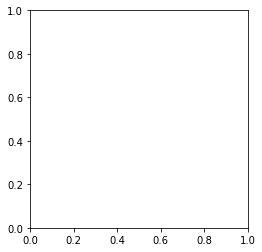

In [13]:
plt.imshow(img)